In [4]:
import scipy as sp; import numpy as np; from matplotlib import pyplot as mp; from numpy import linalg as LA
import networkx as nx; import itertools

In [88]:
with open("pruned_edgelist.net", 'rb') as fh:
    H=nx.read_edgelist(fh)

def spm_iter(H,p):                           #p is the fraction of edges that must chosen as perturbation(here p=10)
    G= H.copy()                              #copy H into G
    
    n_o_n = len(G) ; n_o_e = len(G.edges())  #number of nodes and number of edges respectively

    A = nx.adjacency_matrix(G)               
    ebunch_pos = np.random.choice(range(len(G.edges)),int(np.ceil(n_o_e/p)),replace= False) #choosing p% of G's edges without replacement from ordered edge list
    ebunch = [list(G.edges)[i] for i in ebunch_pos]       #isolating to be removed edges
    G.remove_edges_from(ebunch)                           #removing those edges
    
    
    A_prime = nx.adjacency_matrix(G)                      #A' is new or test adjacency matrix 
    Delta_A = A - A_prime                                 #Delta_A is probe or perturbation adjacency matrix
    w, v = LA.eig(A_prime.todense())                      #w is eigenvalues and v is set of eigenvectors
    Delta_w = [v.T[i].conjugate().dot(Delta_A.todense()).dot(v.T[i].T)[0,0] for i in range(len(w))] #1st order correction to eigenvalues
    Delta = w + Delta_w                                   #perturbative eigenvalues of A' + Delta_A                
    tilde_A = v.dot(np.diag(Delta)).dot(v.T.conjugate())  #tilde_A is perturbative adjacency matrix approximation to A
    
    
    
    A_prime_index_nonzero_double = zip(A_prime.nonzero()[0],A_prime.nonzero()[1])  #locating position of non-zero elements of A'
    A_prime_index_nonzero_single = set(filter(lambda x: x[0] < x[1], A_prime_index_nonzero_double))  #keeping just upper triangular non-zero elements as A' is symmetric

    A_prime_index = set([i for i in list(itertools.combinations(range(n_o_n),2)) if i[0] < i[1] ])   #superset of all possible edges in the graph G

    new_edges = list(A_prime_index.difference(A_prime_index_nonzero_single ))           #set difference gives new edges
    edge_guess_list = np.array([tilde_A[i] for i in new_edges]).argsort()[-int(np.ceil(n_o_e/p)):][::-1]  #list position of top p% of edges as according to edge weight
    edge_guess = [new_edges[i] for i in edge_guess_list]                                #top 10% of edges
    
    sigma_precision = len(np.nonzero([A[j] for j in edge_guess])[0])/np.ceil(n_o_e/p) #number of nodes predicted that were graph H divided total nodes predicted
    
        
    return tilde_A, sigma_precision 
#---------------------------------------------------------------------------------------------------

def spm_loop(H,p,l):                  #l is number of loops that must run
    for i in range(l):
        tilde_A, sigma_precision = spm_iter(H,p)
        if i == 0: Tilde_A = tilde_A
        else: Tilde_A += tilde_A
    
    return Tilde_A/l                   #output is average adjacency matrix
#---------------------------------------------------------------------------------------------------

def link_scores(H,p,l):                 #calculates the average adjacency matrix umder SPM routine. It is composed of weights assigned to the elements of universal 
    Tilde_A = spm_loop(H,p,l)           #set of edges
    for i in range(np.shape(Tilde_A)[0]):
        Tilde_A[(i,i)] = 0
    return Tilde_A                    #diagonal elements of adjacency matrix are set to zero

#---------------------------------------------------------------------------------------------------
#next we define three helpful function
def missing_edge(H):       #calculates all possible missing edges in the graph H
    n_o_n = len(H)
    H_edges = set([(i[0],i[1]) if float(i[0]) < float(i[1]) else (i[1],i[0]) for i in H.edges()])
    universal_edges = set([(str(i[0]),str(i[1])) if float(i[0]) < float(i[1]) else (str(i[1]),str(i[0])) for i in itertools.product(range(n_o_n),range(n_o_n))])
    H_missing_edges = universal_edges.difference(H_edges)
    return H_missing_edges

#---------------------------------------------------------------------------------------------------
str_2_int = lambda tup: (int(tup[0]),int(tup[1]))        #converts string tuple to integer tuple
int_2_str = lambda tup: (str(tup[0]),str(tup[1]))        #converts integer tuple to string tuple
    

## ROC

#### Area under the ROC curve has a simple statistical interpretation: it is the probability that a randomly chosen true missing link will be ranked higher than a randomly chosen false missing link (a missing link known to not-exist). Thus we compare all possible pairs of true and false missing links and calculate the fraction where true missing liks were ranked higher than their random partner from the false missing link set. The fraction gives AUROC and we find it to be greater than (0.5) that given by a random classifier. 

In [107]:
with open("true_missing_links.net", 'rb') as fh:
    H_tm=nx.read_edgelist(fh)

def ROC(H,H_tm,p,l):
    A_tm = nx.adjacency_matrix(H_tm) 
    edge_tm = set([(i[0],i[1]) if float(i[0]) < float(i[1]) else (i[1],i[0]) for i in H_tm.edges()]) #true missing edges from the given file
    tilde_A = link_scores(H,p,l)

    edge_fm = missing_edge(H).difference(edge_tm)   #false missing edges = all possible missing edges - true missing edges

    cartesian_prod_missing = set(itertools.product(edge_tm,edge_fm)) #all possible pairs of true and false missing edges

    ROC = [1 if tilde_A[str_2_int(i[0])] >= tilde_A[str_2_int(i[1])] else 0 for i in cartesian_prod_missing]
    
    return np.sum(ROC)/len(ROC)     


In [79]:
ROC(H,H_tm,10,10)

0.59904885690676213

# AUROC = 0.6

//

//

//

## Precision and Recall

#### Area under Precision-Recall (PR) is a useful metric for performance of a classifier with large number of negative samples, i.e. total missing links $>>$ than the actual links in our case. However, to best of my knowledge there is not simple statistical interpretation for area under the PR curve. So I plot Precision-Recall curve by varying the theshold, T, which in this case I choose to be the total number of top ranked edges chosen after every SPM iteration (top T-ranked edges), and calculate the area numerically. Moreover, since PR curve is ill-defined for Recall values close to zero, the numerical  area is calculated for Recall values ranging from 0.2-1. This is compared against area under a random classifier with constant precision of $$P_{random} = TME/N \approx 0.01 $$
#### where TME is total number of true missing Edges and N is the universal set of missing links.

In [1]:
def precision_recall(H,H_tm,p,l,t_hold):
    G= H.copy()                              
    n_o_n = len(G) 
    
    A_tm = nx.adjacency_matrix(H_tm) 
    edge_tm = set([(i[0],i[1]) if float(i[0]) < float(i[1]) else (i[1],i[0]) for i in H_tm.edges()])
    tilde_A = link_scores(G,p,l)
    
    new_edges = list(missing_edge(G))
    edge_guess_list = np.array([tilde_A[str_2_int(i)] for i in new_edges]).argsort()[-t_hold:][::-1] 
    
    edge_guess = [new_edges[i] for i in edge_guess_list]                                
    sigma_precision = len(edge_tm & set(edge_guess))/len(edge_guess)  #definition of precision
    sigma_recall = len(edge_tm & set(edge_guess))/len(edge_tm)        #definition of recall
    
    return sigma_precision, sigma_recall


    

In [163]:
Th = [100,150,200,250,300,350,450,600,700,800,1000,1200,1400,1800,2400,3000,4000,5000,6000,8000,12000,16000,2000]
#Th is the theshold, for Th = 450 (say) we chose top 450 edges from the average adjacency matrix.
PR = {}
for i in Th:
    p,r = precision_recall(H,H_tm,10,10,i)
    PR[i] = (p,r)

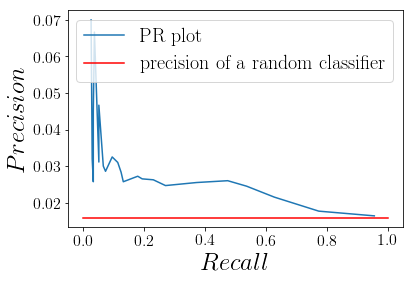

In [210]:
p_list = [PR[i][0] for i in PR.keys()]; r_list = [PR[i][1] for i in PR.keys()]
zipped = sorted(zip(r_list, p_list))
X = [i[0] for i in zipped] ; Y = [i[1] for i in zipped]

from matplotlib import pyplot as mp
fig = mp.figure(); ax = fig.add_subplot(111) 
from matplotlib import rcParams
rcParams['mathtext.default']='regular'
mp.rc('text', usetex=True) ; mp.rc('font', family='serif')

mp.plot(X,Y)

tru_misng_lnk = len(set([(i[0],i[1]) if float(i[0]) < float(i[1]) else (i[1],i[0]) for i in H_tm.edges()]))
ttal_misng_lnk = len(missing_edge(H))
mp.plot(np.linspace(0,1,50),(tru_misng_lnk/ttal_misng_lnk)*np.ones(50),'red')
       
mp.ylabel(r'$Precision$',fontsize = 25)
mp.rcParams['xtick.labelsize'] = 16
mp.rcParams['ytick.labelsize'] = 16
mp.xlabel(r'$Recall$',fontsize = 25)
mp.legend(['PR plot','precision of a random classifier'],fontsize=20)
mp.show()

In [226]:
AUCPR = 0
for i in range(len(X[15:])):
    AUCPR += (X[15+i] - X[15+i-1])*Y[i] 
AUCPR += (1 - X[-1])*tru_misng_lnk/ttal_misng_lnk
AUCPR      #area under precion-recall curve between recall ranging from 0.2 to 1

0.03102395413882722

# AUCPR = 0.031